# Depth Anything 3 (DA3) Usage Example

This notebook demonstrates how to use Depth Anything 3 for camera poses and depth estimation.


In [ ]:
# Install required packages
# !pip install depth-anything-3

In [1]:
import sys
import os

# Get the current working directory (notebooks/)
current_dir = os.getcwd()

# Get the parent directory (depth_anything_v3/)
parent_dir = os.path.dirname(current_dir)

# Add the src directory to sys.path
src_dir = os.path.join(parent_dir, 'src')
sys.path.insert(0, src_dir)

# Now import directly from depth_anything_3
from depth_anything_3.api import DepthAnything3

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
# from depth_anything_3.api import DepthAnything3
from depth_anything_3.utils.visualize import visualize_depth
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DepthAnything3.from_pretrained("depth-anything/da3-base")
model = model.to(device)
model.eval()
print(f"Model loaded on {device}")

[INFO ] using MLP layer as FFN
Model loaded on cuda


In [3]:
# Load sample images and run inference
image_paths = [
    "../assets/examples/SOH/000.png",
    "../assets/examples/SOH/010.png"
]

# Run inference
prediction = model.inference(
    image=image_paths,
    process_res=504,
    process_res_method="upper_bound_resize",
    export_dir=None,
    export_format="glb"
)
print(f"Depth shape: {prediction.depth.shape}")
print(f"Extrinsics: {prediction.extrinsics.shape if prediction.extrinsics is not None else 'None'}")
print(f"Intrinsics: {prediction.intrinsics.shape if prediction.intrinsics is not None else 'None'}")


[INFO ] Processed Images Done taking 0.07564949989318848 seconds. Shape:  torch.Size([2, 3, 280, 504])
[INFO ] Model Forward Pass Done. Time: 0.5353262424468994 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0012183189392089844 seconds
Depth shape: (2, 280, 504)
Extrinsics: (2, 3, 4)
Intrinsics: (2, 3, 3)


In [3]:
image_path = "../assets/examples/SOH/000.png"
image = np.array(Image.open(image_path))
# image_tensor = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).unsqueeze(0)
# image_tensor = image_tensor.to(device)

# prediction = model._preprocess_inputs(image=[image])

# Preprocess images
imgs_cpu, extrinsics, intrinsics = model._preprocess_inputs(
    image=[image], 
    # extrinsics, intrinsics, 
    process_res=504, process_res_method="upper_bound_resize"
)

# Prepare tensors for model
imgs, ex_t, in_t = model._prepare_model_inputs(imgs_cpu, extrinsics, intrinsics)

# Normalize extrinsics
ex_t_norm = model._normalize_extrinsics(ex_t.clone() if ex_t is not None else None)

# Run model forward pass
export_feat_layers = []

raw_output = model._run_model_forward(
    imgs, ex_t_norm, in_t, export_feat_layers,
)

# Convert raw output to prediction
prediction = model._convert_to_prediction(raw_output)

# Align prediction to extrinsincs
prediction = model._align_to_input_extrinsics_intrinsics(
    extrinsics, intrinsics, prediction, align_to_input_ext_scale=True
)

# Add processed images for visualization
prediction = model._add_processed_images(prediction, imgs_cpu)

[INFO ] Processed Images Done taking 0.06289505958557129 seconds. Shape:  torch.Size([1, 3, 280, 504])
[INFO ] Model Forward Pass Done. Time: 0.5031840801239014 seconds
[INFO ] Conversion to Prediction Done. Time: 0.002264261245727539 seconds


In [ ]:
image.shape, prediction.depth[0].shape

((680, 1208, 3), (280, 504))

: 

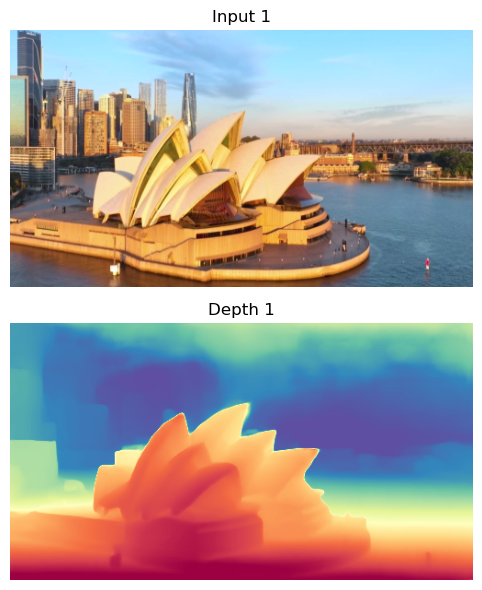

In [5]:
# Visualize input images and depth maps
n_images = prediction.depth.shape[0]

fig, axes = plt.subplots(2, n_images, figsize=(12, 6))

if n_images == 1:
    axes = axes.reshape(2, 1)

for i in range(n_images):
    # Show original image
    if prediction.processed_images is not None:
        axes[0, i].imshow(prediction.processed_images[i])
    axes[0, i].set_title(f"Input {i+1}")
    axes[0, i].axis('off')
    
    # Show depth map
    depth_vis = visualize_depth(prediction.depth[i], cmap="Spectral")
    axes[1, i].imshow(depth_vis)
    axes[1, i].set_title(f"Depth {i+1}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()